Descomprimimos la carpeta comprimida Malware.zip

In [2]:
from zipfile import ZipFile
import os

zip_filename = 'Recursos Lab3.zip'
base_dir = os.path.splitext(zip_filename)[0] + '/'

if not os.path.exists(base_dir):
    with ZipFile(zip_filename, 'r') as zf:
        for file in zf.namelist():
            if file.startswith(base_dir):
                zf.extract(file) 

In [3]:
import os
import zipfile

zip_filename = 'Malware.zip'
output_dir = os.path.splitext(zip_filename)[0] + '/'
output_dir = os.path.join(base_dir, output_dir)

if not os.path.exists(output_dir):
    with zipfile.ZipFile(os.path.join(base_dir, zip_filename)) as zf:
        zf.extractall(path=base_dir)

In [65]:
import cv2

data = dict()
labels = os.listdir(output_dir)
for label in labels:
    data[label] = []
    class_dir = os.path.join(output_dir, label)
    for image in os.listdir(class_dir):
        image = cv2.imread(os.path.join(class_dir, image), cv2.IMREAD_GRAYSCALE)        
        data[label].append(image)

In [66]:
for label in os.listdir(output_dir):
    print(label, data[label][0].shape)

Agent.FYI (257, 64)
Fakerean (273, 384)
Lolyda.AA1 (400, 64)
Yuner.A (683, 768)


Las imágenes de cada clase tienen dimensiones distintas, tomaremos como dimensiones estándar las menores existentes.  
En este caso la clase Agent.FYI que tiene dimensiones 257, 64.   
Entonces, redimensionaremos el resto de clases a las dimensiones estándar.

In [67]:
labels = os.listdir(output_dir)
std_label, *non_std_labels = labels
std_size = data[std_label][0].shape

for label in labels:
    for i, image in enumerate(data[label]):
        data[label][i] = cv2.resize(image, std_size[::-1]) # due to cv2.resize use (width, height) we reverse dimensions

In [68]:
for label in os.listdir(output_dir):
    print(label, data[label][0].shape)

Agent.FYI (257, 64)
Fakerean (257, 64)
Lolyda.AA1 (257, 64)
Yuner.A (257, 64)


Podemos ver un ejemplo de cada clase

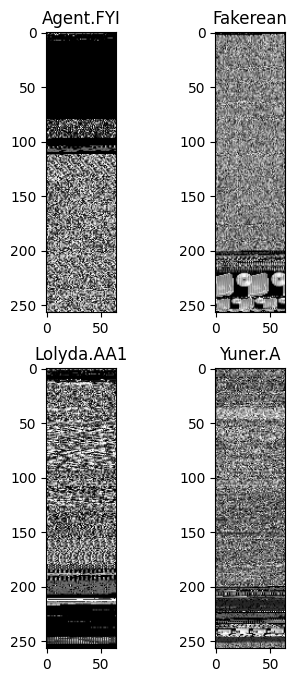

In [90]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(4, 8))

for idx, label in enumerate(data):
    row = idx // 2
    col = idx % 2
    axs[row, col].imshow(data[label][0], cmap='gray')
    axs[row, col].set_title(label)

plt.show()